# What drives the price of a car?

![](images/kurt.jpeg)

In [198]:
import pandas as pd 
import numpy as np
import statistics
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa.arima_process as arima_process 

from numpy import cov
from random import shuffle 
from category_encoders import TargetEncoder

from matplotlib.pyplot import figure
from matplotlib import pyplot
import matplotlib.pyplot as plt

#from sklearn.preprocessing import StandardScalar
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.inspection import permutation_importance


from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.seasonal import _extrapolate_trend, seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

**OVERVIEW**

In this application, you will explore a dataset from kaggle that contains information on 3 million used cars.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The business goal is to identify the features that will be most influential in raising the price of a used car. In order to determine the extent to which any given factor affects the price of a used car, the data task would be to fit a regression model that predicts the price of a used car given its features. After fine-tuning and evaluating the model's ability to make reliable and accurate predictions beyond the scope of its training data, the model can then be utilized to gauge the effect of each individual feature on the price of the car. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. Identify the distribution of missing values in the dataset
2. Take care of missing values
3. Encode categorical variables into numeric format 
4. Visualise the distribution of features, take care of outliers, and transform skewed features 
5. Test for correlation and multicollinearity 
6. Determine the best features for predicting price using SequentialFeatureSelector
7. Drop unnecessary columns and build the final dataset

In [199]:
pd.set_option("display.max_columns", None)
df = pd.read_csv("/Users/lois/Desktop/ML/Module 11/practical_application_II_starter/data/vehicles.csv")
df.head(3)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl


#### Handling Missing Values 
There are quite a few null in this dataset. The original dataset has 426880 rows, and dropping all the values would leave only 34868 records.


##### Barplot of Percent Null by Column 

In [200]:
#create df of percent null of each column
percent_null = df.isnull().sum() * 100 / len(df)
missing_df = pd.DataFrame({"col_name" : df.columns, 
                          "percent_null" : np.round(percent_null, 2)})
missing_df

,col_name,percent_null
id,id,0.00
region,region,0.00
price,price,0.00
year,year,0.28
manufacturer,manufacturer,4.13
model,model,1.24
condition,condition,40.79
cylinders,cylinders,41.62
fuel,fuel,0.71
odometer,odometer,1.03


[Text(0.5, 0, 'Column Name'),
 Text(0, 0.5, 'Percent Null'),
 Text(0.5, 1.0, 'Percent Null by Column')]

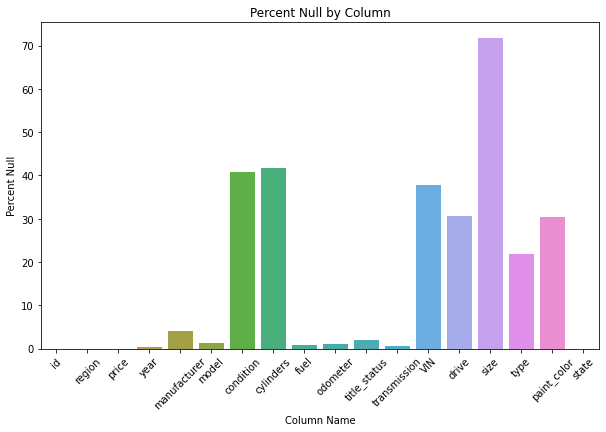

In [201]:
plt.figure(figsize = (10, 6))
fig = sns.barplot(x = "col_name", y = "percent_null", data = missing_df)
plt.xticks(rotation = 45)

fig.set(xlabel = "Column Name", ylabel = "Percent Null", title = "Percent Null by Column")

##### Drop missing values in categorical columns with relatively few missing values

In [202]:
df.dropna(subset=['year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission'], inplace = True) 

##### Imputing remaining categorical columns with with the mode


In [203]:
df["condition"].fillna(df["condition"].mode().to_string(), inplace = True)
df["cylinders"].fillna(df["cylinders"].mode().to_string(), inplace = True)
df["drive"].fillna(df["drive"].mode().to_string(), inplace = True)
df["size"].fillna(df["size"].mode().to_string(), inplace = True)
df["type"].fillna(df["type"].mode().to_string(), inplace = True)
df["paint_color"].fillna(df["paint_color"].mode().to_string(), inplace = True)

#df.isna().sum()

#### Encoding Categorical Data into Numeric Format

##### Target Encoding Nominal Columns 

In [204]:
te = TargetEncoder()
encoded_df = te.fit_transform(df[["region", "manufacturer", "model", "type", "paint_color", "state", "fuel", "drive", "transmission"]], df["price"])

In [205]:
#combining encoded and original dataframe 
df.drop(['region', 'manufacturer', 'model', 'type', 'paint_color', 'state',
       'fuel', 'drive', 'transmission'], axis = 1, inplace = True)
df = pd.concat([df, encoded_df], axis = 1)
df.shape

(389604, 18)

##### Converting Ordinal Categorical Columns to Integer Datatype

In [206]:
#converting size to a scale of 1-4
#deleting values where size = '0    4'
#combining "full-size" and "0  full-size" columns
#full-size > mid-size > compact > sub-compact

df = df[df["size"] != '0    4']
df["size"].replace({"0    full-size" : 4, "full-size" : 4, "mid-size" : 3, "compact" : 2, "sub-compact" : 1}, inplace = True)
#df["size"].unique()

In [207]:
#combining "white" and "0    white" columns
df["paint_color"].replace({"0    white" : "white"}, inplace = True)

In [208]:
#converting condition to numeric
#dropping "0    good" column
#using a scale of 1-6 corresponding to new > excellent > like new > good > fair > salvage 

df = df[df["condition"] != '0    good']
df["condition"].replace({"new" : 6, "excellent" : 5, "like new" : 4, "good" : 3, "fair" : 2, "salvage" : 1}, inplace = True)

#converting values to Int
df["condition"] = df["condition"].astype(int)

In [209]:
#converting number of cylinders to int values
#combining the "6 cylinders" 
#deleting rows with value = "0    6 cylinders" 
# filling in "other" with the mode, which is 6

df = df[df["cylinders"] != "0    6"]
df["cylinders"].replace({"8 cylinders" : 8, "6 cylinders" : 6, "0    6 cylinders" : 6, \
                         "5 cylinders" : 5, "4 cylinders" : 4, "10 cylinders" : 10, \
                         "3 cylinders" : 3, "12 cylinders" : 12, "other" : 6}, inplace = True)

#df["cylinders"].unique()

In [210]:
#converting title_status to numeric ratings on a scale of 1-6
#clean > lien > rebuilt > missing > salvage > parts only 

df["title_status"].replace({"clean" : 6, "lien" : 5, "rebuilt" : 4, "missing" : 3, "salvage" : 2, "parts only" : 1}, inplace = True)
#df["title_status"].unique()

In [211]:
#converting datatypes 
df = df.convert_dtypes()

#### Checking for Duplicate ID values

In [212]:
df.id.duplicated().sum()

0

#### Outlier Analysis
Visualise the distribution of features and take care of outliers



In [213]:
#only keeping records where the price is between $150-50,000
df = df[(df["price"] >= 150) & (df["price"] <= 70000)]

In [214]:
df.shape

(220800, 18)

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [215]:
#checking skew of data
df.agg(["skew"]).transpose()

,skew
id,-0.630330
price,0.789593
year,-3.222202
condition,0.189426
cylinders,0.100428
odometer,43.495808
title_status,-5.945284
size,-2.572930
region,10.005744
manufacturer,3.092377


[Text(0.5, 1.0, 'Distribution of Price')]

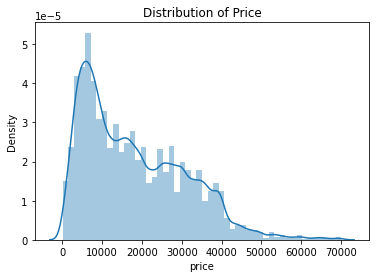

In [216]:
#checking the distribution of price column
sns.distplot(df['price']).set(title = "Distribution of Price")

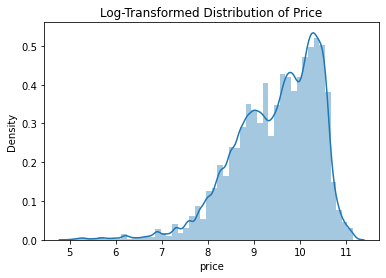

In [217]:
#log transform price column
df['price'] = np.log(df['price'])

sns.distplot(df['price']).set(title = 'Log-Transformed Distribution of Price');

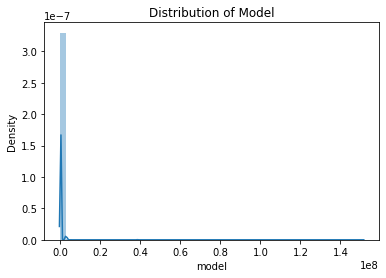

In [218]:
#checking the distribution of model column
sns.distplot(df['model']).set(title = 'Distribution of Model');

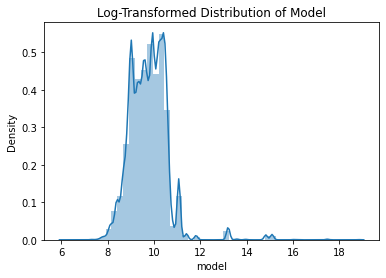

In [219]:
#log transform model column
df['model'] = np.log(df['model'])

sns.distplot(df['model']).set(title = 'Log-Transformed Distribution of Model');

#### Correlation Analysis for Numeric Columns 

- Transmission and year have a moderate correlation
- Region and state has a strong correlation, which is to be expected; neither column will be used in model training
- The features that have a correlation score of at least +/- 0.1 with price are year, cylinders, odometer, title_status, size, model, fuel, drive, and transmission.

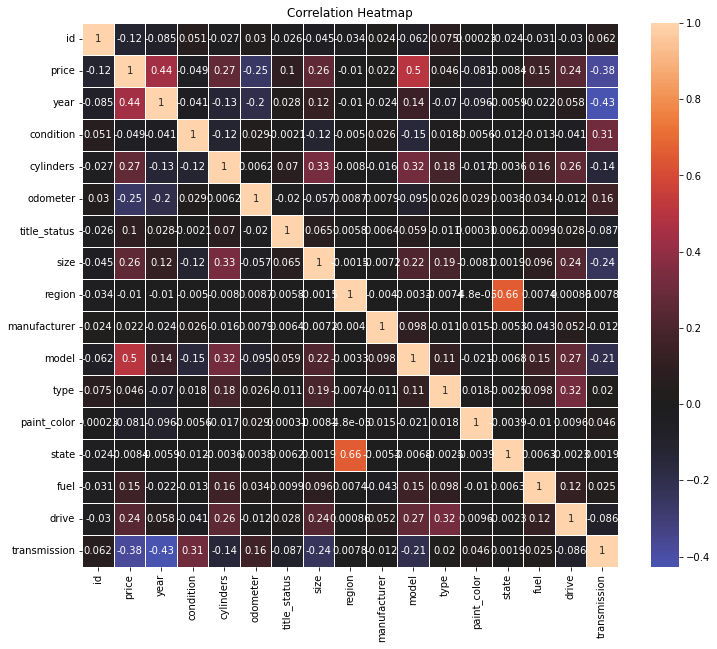

In [220]:
#correlation heatmap  

sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(df.corr(), center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');

In [426]:
#splitting data 
X = df.drop(["price", "VIN"], axis = 1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .3)

### Sequential Feature Selection 
SequentialFeatureSelector was implemented to find the best 10 features to train models, and this was cross-validated with 5-fold cross validation. The evaluation metric that will be used in this project is neg_mean_squared_error. This evaluation metric was chosen because we will be fitting regression models that can predict the price of a used car. The MSE effectively measures the quality of a model by comparing the predicted values generated from the training data with the actual values in the dataset. The reason neg_mean_squared_error is used is because the best model has a low sum of squared differences of the predicted and actual price values.

In [427]:
sfs = SequentialFeatureSelector(estimator = LinearRegression(),
                                scoring = "neg_mean_squared_error",
                                cv = 5,
                                n_features_to_select = 10)

In [428]:
sfs.fit(X, y)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=10,
                          scoring='neg_mean_squared_error')

In [246]:
sfs.get_feature_names_out(input_features=None)

array(['id', 'year', 'condition', 'cylinders', 'odometer', 'size',
       'model', 'fuel', 'drive', 'transmission'], dtype=object)

#### Finalise the Dataset for Model Training

In [247]:
final_df = df[['id', 'year', 'condition', 'cylinders', 'odometer', 'size',
       'model', 'fuel', 'drive', 'transmission', 'price']]

### Modeling


In [248]:
#splitting data 
X = final_df.drop("price", axis = 1)
y = final_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .3)

#### Linear Regression Model
The MSE of the basic linear regression model is 0.437.

In [249]:
#fitting a linear regression model
lr = LinearRegression(fit_intercept = True)
lr_model = lr.fit(X_train, y_train)

In [250]:
lr_mse = mean_squared_error(lr_model.predict(X_test), y_test)
print(f"MSE of linear regression model is {np.round(lr_mse, 3)}")

MSE of linear regression model is 0.437


#### Simple Cross Validation
Implementing simple cross validation to find the degree of the best model by writing a function that iterates through complexities from 1-6, builds a model with a degree of that complexity, and returns the model with the lowest test mean squared error. Using simple cross validation, the linear regression model with degree 3 has the lowest MSE of 0.248.

In [152]:
#GridSearchCV to find best degree
#write a function that returns the best Pipeline model 

def simple_cross_validation(X_train, y_train, X_test, y_test):
    best_pipe = None
    best_mse = np.inf

    for complexity in range(1, 5):
        pipe = Pipeline([
            ("transform", PolynomialFeatures(degree = complexity, include_bias = False)),
            ("scaler", StandardScaler()),
            ("regression", LinearRegression())
        ])

        pipe.fit(X_train, y_train)
        
        test_mse = mean_squared_error(pipe.predict(X_test), y_test)

        if test_mse < best_mse:
            best_mse = test_mse
            best_pipe = pipe
    return best_pipe

In [153]:
best_model = simple_cross_validation(X_train, y_train, X_test, y_test)
best_model.get_params()

{'memory': None,
 'steps': [('transform', PolynomialFeatures(degree=3, include_bias=False)),
  ('scaler', StandardScaler()),
  ('regression', LinearRegression())],
 'verbose': False,
 'transform': PolynomialFeatures(degree=3, include_bias=False),
 'scaler': StandardScaler(),
 'regression': LinearRegression(),
 'transform__degree': 3,
 'transform__include_bias': False,
 'transform__interaction_only': False,
 'transform__order': 'C',
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'regression__copy_X': True,
 'regression__fit_intercept': True,
 'regression__n_jobs': None,
 'regression__normalize': 'deprecated',
 'regression__positive': False}

In [416]:
best_pipe_mse = mean_squared_error(y_test, best_model.predict(X_test))
print(f"MSE for Linear Regression model of degree 3 is {best_pipe_mse}")

MSE for Linear Regression model of degree 3 is 0.2476004656574619


#### Lasso Regression Model with GridSearchCV

GridSearchCV was implemented to find the optimal alpha value for a lasso regression model, using the evaluation metric of neg_mean_squared_error. Using 3-fold cross validation, the lasso regression model with alpha = 0.0001 has the lowest MSE of 0.260. 

In [373]:
#dictionary of alpha values for GridSearchCV
alphas = {"lasso__alpha" : [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

In [375]:
#building a an unfit lasso model 
lasso_pipe = Pipeline([
    ("transform", PolynomialFeatures(degree = 3, include_bias = False)),
    ("scale", StandardScaler()),
    ("lasso", Lasso())
])

In [379]:
#GridSearchCV to find optimal alpha hyperparameter 
model_finder = GridSearchCV(estimator = lasso_pipe,
                            param_grid = alphas,
                            scoring = "neg_mean_squared_error",
                            cv = 3)                            

In [382]:
model_finder.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transform',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('scale', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                          100.0]},
             scoring='neg_mean_squared_error')

In [418]:
best_estimator = model_finder.best_estimator_
best_estimator

Pipeline(steps=[('transform', PolynomialFeatures(degree=3, include_bias=False)),
                ('scale', StandardScaler()), ('lasso', Lasso(alpha=0.0001))])

In [504]:
#instantiate and fit lasso model with optimal hyperparameters
lasso_model = Pipeline([
    ("transform", PolynomialFeatures(degree = 3, include_bias = False)),
    ("scale", StandardScaler()),
    ("lasso", Lasso(alpha = 0.0001))
]) 

lasso_model.fit(X, y)

Pipeline(steps=[('transform', PolynomialFeatures(degree=3, include_bias=False)),
                ('scale', StandardScaler()), ('lasso', Lasso(alpha=0.0001))])

In [505]:
grid_lasso_mse = mean_squared_error(y_test, lasso_model.predict(X_test)) 
print(f"Grid Lasso MSE is {grid_lasso_mse}")

Grid Lasso MSE is 0.25968484357090826


### Ridge Regression Model with GridSearchCV

GridSearchCV was implemented to find the optimal alpha value for the ridge regression model, using the evaluation metric of neg_mean_squared_error. Using 5-fold cross validation, the ridge regression model with alpha = 0.0001 has the lowest MSE of 0.217.

In [406]:
#dictionary of alpha values for GridSearchCV
alphas = {"ridge__alpha" : [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}

In [407]:
#building a an unfit ridge model 
ridge_pipe = Pipeline([
    ("transform", PolynomialFeatures(degree = 3, include_bias = False)),
    ("scale", StandardScaler()),
    ("ridge", Ridge())
])

In [408]:
#GridSearchCV to find optimal alpha hyperparameter 
ridge_grid = GridSearchCV(estimator = ridge_pipe,
                            param_grid = alphas,
                            scoring = "neg_mean_squared_error",
                            cv = 5)                            

In [409]:
ridge_grid.fit(X, y) 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('scale', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]},
             scoring='neg_mean_squared_error')

In [509]:
ridge_best_estimator = ridge_grid.best_estimator_
ridge_best_estimator

Pipeline(steps=[('transform', PolynomialFeatures(degree=3, include_bias=False)),
                ('scale', StandardScaler()), ('ridge', Ridge(alpha=0.0001))])

In [542]:
#ridge_grid.cv_results_

In [541]:
#instantiate and fit Ridge model 
ridge_model = Pipeline([
    ("transform", PolynomialFeatures(degree = 3, include_bias = False)),
    ("scale", StandardScaler()),
    ("ridge", Ridge(alpha = 0.0001))
]) 

ridge_model.fit(X, y)

In [531]:
grid_ridge_mse = mean_squared_error(y_test, ridge_model.predict(X_test))
print(f"MSE of grid ridge models is {grid_ridge_mse}")

MSE of grid ridge models is 0.2170497121256632


### Evaluation
The Ridge Regression model with alpha = 0.0003 had the lowest MSE of 0.217. 

### Permutation Importance 
The result of implementing permutation importance reveals that the features that contributed most to the model predicting price are year, model, odometer, and transmission. 

#### Permutation Importance of Linear Regression Model of Degree 3 

In [262]:
r = permutation_importance(pipe, X_test, y_test, n_repeats = 50, random_state = 42)

In [263]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i] : <8}:"
             f"{r.importances_mean[i] : .3f}"
             f"+/- {r.importances_std[i] : .3f}")

year    : 0.302+/-  0.004
model   : 0.268+/-  0.003
odometer: 0.108+/-  0.017
transmission: 0.053+/-  0.005
condition: 0.052+/-  0.002
cylinders: 0.050+/-  0.011
drive   : 0.039+/-  0.003
fuel    : 0.036+/-  0.011
size    : 0.029+/-  0.011


#### Permutation Importance of Ridge Model

In [293]:
r = permutation_importance(ridge_grid, X_test, y_test, n_repeats = 50, random_state = 42)

In [294]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i] : <8}:"
             f"{r.importances_mean[i] : .3f}"
             f"+/- {r.importances_std[i] : .3f}")

model   : 0.235+/-  0.002
year    : 0.203+/-  0.002
odometer: 0.100+/-  0.008
condition: 0.047+/-  0.001
transmission: 0.044+/-  0.002
cylinders: 0.038+/-  0.002
drive   : 0.030+/-  0.001
fuel    : 0.022+/-  0.004
size    : 0.013+/-  0.002
id      : 0.002+/-  0.000


#### Comparing Ridge Regression and Linear Regression Models
The most important features for the ridge and linear regression models are model, year, odometer, and condition, but the order of importance differs in the two models. The correlation degree of the top five features with price more closely match the ordering of the ridge regression model, which could explain why it had the lower MSE of the two. 

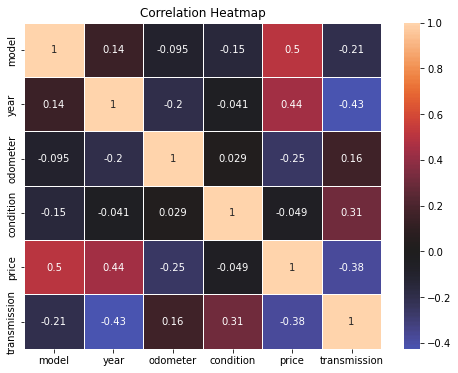

In [435]:
#df of top 5 features with price
top_five = final_df[["model", "year", "odometer", "condition", "price", "transmission"]]

#correlation heatmap  
sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(top_five.corr(), center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');